In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from birdclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/01 07:15:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/01 07:15:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [22]:
root = "../data/processed/birdclef-2023/train_embeddings"
df = spark.read.parquet(f"{root}/consolidated_v3_sample")

In [23]:
df.select("track_name").distinct().count()

175

In [24]:
df.show()

+-------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|species|track_stem|track_type|          track_name|           embedding|      prediction_vec|         predictions|start_time|              energy|
+-------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|malkin1|  XC132986|  original|malkin1/XC132986.mp3|[0.75343722105026...|[-10.260432243347...|[{0, 2342, Phyllo...|        36| 0.25369036197662354|
|refwar2|  XC128009|   source1|refwar2/XC128009_...|[0.19527475535869...|[-9.6245841979980...|[{0, 684, Cinclor...|        36|  20.364137649536133|
|malkin1|  XC132986|  original|malkin1/XC132986.mp3|[1.32953834533691...|[-13.427273750305...|[{0, 890, Culicic...|        69| 0.18416672945022583|
|refwar2|  XC128009|  original|refwar2/XC128009.mp3|[1.89621150493621...|[-17.041515350341...|[{0, 185, Anthus .

In [29]:
# scatter plot
res = (
    df.select("species", "embedding", F.explode("predictions").alias("predictions"))
    .select("species", "embedding", "predictions.*")
    .where("probability > 0.5")
)
res.show()

+-------+--------------------+----+-----+--------------------+------------+------------------+
|species|           embedding|rank|index|               label|mapped_label|       probability|
+-------+--------------------+----+-----+--------------------+------------+------------------+
|refwar2|[0.99149847030639...|   0| 1450|Human vocal_Human...|      humvoc|0.6938544511795044|
|refwar2|[1.43871796131134...|   0| 2491|Prinia sylvatica_...|     junpri1|0.8636960387229919|
|malkin1|[1.16651332378387...|   0| 1640|Limnothlypis swai...|      swawar|0.5569329857826233|
|malkin1|[1.23353230953216...|   0|  696|Cinnyris jugulari...|     olbsun4|0.6094335913658142|
|malkin1|[1.14792478084564...|   0| 2332|Phylloscopus orie...|     eabwar1|0.5228896737098694|
|bltapa1|[0.71383780241012...|   0| 3301|Xiphorhynchus sus...|     cocwoo1|0.8647496104240417|
|bltapa1|[0.98918461799621...|   0| 3301|Xiphorhynchus sus...|     cocwoo1| 0.801962673664093|
|bltapa1|[0.98918461799621...|   1| 1245|Furnarius

(127, 320)


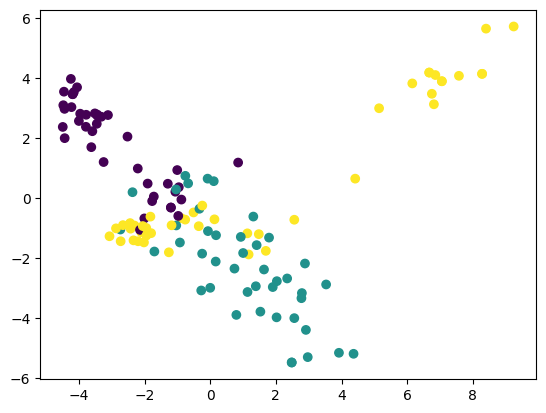

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

pdf = res.toPandas()
X = np.stack(pdf["embedding"].values)
print(X.shape)
y = pdf["species"].values
colors = {k: i for i, k in enumerate(np.unique(y))}
pca = PCA(n_components=2)
g = pca.fit_transform(X)
plt.scatter(g[:, 0], g[:, 1], c=[colors[k] for k in y])
plt.show()